In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Applied \AI \course \Assignments/Case \Study \2

/content/drive/MyDrive/Applied AI course Assignments/Case Study 2


In [ ]:
pip install tensorflow-addons==0.11.2

     |████████████████████████████████| 1.1MB 7.7MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import cv2
from skimage import io
from skimage import transform
from skimage import color
import pickle

import pathlib
import datetime
import os
import pickle
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import tensorflow_addons as tfa

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
# # Script to load the images from 4 folders
# # Images and labels are in 4 folders namely A1, A2, A3, A4.
# # Each contains a csv file with the leaf counts for the corresponding images
# # Note csv file does not contain headers. Add headers to easily use pandas functions

# # Note that some of the given images are RGBA images. Majority of them are rgb images
# images = []
# counts = []

# data_path = "CVPPP_dataset"

# folders = os.listdir(data_path)

# image_index = 0

# for folder in folders:
#     cur_path = data_path + '/' + folder
#     csv_path = data_path + '/' + folder + '/' + folder + '.csv'
#     # Read the csv file as dataframe
#     counts_csv = pd.read_csv(csv_path)
#     #List the image files
#     files = os.listdir(cur_path)
#     for file in files:
#         # Filtering image files that are actual RGB images(not segmentation masks or leaf center images)
#         if file.split('.')[1] == 'png' and file.split('.')[0].split('_')[1] == 'rgb':
#             image_path = cur_path + '/' + file
            
#             # Save the image path with the corresponding counts
#             images.append(image_path)
#             counts.append(counts_csv[counts_csv['Image_name'] == file]['Count'].values[0])
# '''

# '''# Save the images and counts

# with open('Images.pkl', 'wb') as f:
#   pickle.dump(images, f)

# with open('Counts.pkl', 'wb') as f:
#   pickle.dump(counts, f)


In [ ]:
# Load the images and counts
with open('Images.pkl', 'rb') as f:
  images = pickle.load(f)

with open('Counts.pkl', 'rb') as f:
  counts = pickle.load(f)


## Test sets for final evaluation and analysis:

Each set would contain all images from the folder. So we would ha 4 sets, one for each folder containing all the images in that folder.

In [ ]:
test_example = "CVPPP_dataset/A4/plant0055_rgb.png"

In [ ]:
test_example.split("/")[1]

'A4'

## Tf data pipeline

In [ ]:
#Total images are 810
#Going for 80-10-10 split

X_train, X_test, y_train, y_test = train_test_split(images, counts, random_state = 5, shuffle=True, test_size= 0.20)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state = 5, shuffle = True, test_size = 0.50)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [ ]:
# Load the segmentation model

segnet_model = tf.keras.models.load_model("saved_models/saved_segmentation_model")

# Load the images and masks from paths
@tf.function
def get_images_and_counts(image_path, count):
    # Read the image path
    image = tf.io.decode_png(tf.io.read_file(image_path), channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float64)
    # Resizing
    #image = tf.image.resize(image, [448, 448])  # Based on the values from the paper
    image = tf.image.resize(image, [224, 224])
    return image, count


# Data augmentation
@tf.function
def data_augmentation_and_mask_concatenation(image, count):
    random_number = tf.random.uniform(shape = [], maxval = 5, dtype = tf.int32)

    # ==1 then apply rotation
    if tf.equal(random_number, tf.constant(1)):
        image = rotate_image(image)
    
    # ==2 then apply horizontal flip
    elif tf.equal(random_number, tf.constant(1)):
        image = random_horizontal_flip(image)
        
    # ==3 then apply vertical flip
    elif tf.equal(random_number, tf.constant(1)):
        image = random_vertical_flip(image)
            
    # ==4 then apply gaussian blur
    elif tf.equal(random_number, tf.constant(1)):
        #image, mask = gaussian_blur(image, mask)
        pass # Since current environment version does not support the tf gaussian blur function
        
    # ==5 No augmentation
    else:
        pass
    
    #Get the mask from saved segmentation model
    #image_for_segmentation = tf.image.resize(image, [224, 224])
    image_for_segmentation = tf.reshape(image, [1 ,224, 224, 3])
    mask = segnet_model(image_for_segmentation, training = False)[0]      # Return batch of 1 predicted image. Hence select the 0th element to get the prediction
    #mask = tf.image.resize(mask, [448, 448])   # Tensorshape = [448, 448, 1]

    # Convert the mask values to boolean
    threshold = 0.5
    cond = tf.greater(mask, tf.ones(tf.shape(mask))*threshold)
    boolean_mask = tf.where(cond, tf.ones(tf.shape(mask)), tf.zeros(tf.shape(mask)))

    # Concatenate the image with mask(as the 4th channel)
    #combined_image = tf.concat([mask, image], axis = -1)   # Tensorshape = [448, 448, 4]
    combined_image = tf.multiply(image, boolean_mask)    # Tensorshape = [448, 448, 3]
    combined_image = tf.image.resize(combined_image, [448, 448])
    return combined_image, count


# Augmentation helpers
#https://stackoverflow.com/a/53780220/11916806
'''@tf.function
def gaussian_blur(image, mask):
    image = tfa.image.gaussian_filter2d(image, filter_shape = 100, sigma = 16.6, padding = "SYMMETRIC")
    return image, mask'''

# Functions to flip images(50% chance)
@tf.function
def random_horizontal_flip(image):
    random_num = tf.random.uniform([], 0, 1.0)
    cond_value = tf.less(random_num, 0.5)
    image = tf.cond(cond_value, lambda: tf.image.flip_left_right(image), lambda: image)
    #mask = tf.cond(cond_value, lambda: tf.image.flip_left_right(mask), lambda: mask)
    return image

@tf.function
def random_vertical_flip(image):
    random_num = tf.random.uniform([], 0, 1.0)
    cond_value = tf.less(random_num, 0.5)
    image = tf.cond(cond_value, lambda: tf.image.flip_up_down(image), lambda: image)
    #mask = tf.cond(cond_value, lambda: tf.image.flip_up_down(mask), lambda: mask)
    return image

# Function to rotate images by 4 degrees
@tf.function
def rotate_image(image):
  # Angle in degrees
    image = tfa.image.rotate(image, 180, interpolation = "NEAREST")  
    #mask = tfa.image.rotate(mask, 180, interpolation = "NEAREST")
    return image

# Function to get the image mask and concatenate with input image without data augmentation(for validation and test data)
@tf.function
def mask_concatenation(image, count):
    #Get the mask from saved segmentation model
    #image_for_segmentation = tf.image.resize(image, [224, 224])
    image_for_segmentation = tf.reshape(image, [1 ,224, 224, 3])
    mask = segnet_model(image_for_segmentation, training = False)[0]      # Return batch of 1 predicted image. Hence select the 0th element to get the prediction
    #mask = tf.image.resize(mask, [448, 448])   # Tensorshape = [448, 448, 1]

    # Convert the mask values to boolean
    threshold = 0.5
    cond = tf.greater(mask, tf.ones(tf.shape(mask))*threshold)
    boolean_mask = tf.where(cond, tf.ones(tf.shape(mask)), tf.zeros(tf.shape(mask)))

    # Concatenate the image with mask(as the 4th channel)
    #combined_image = tf.concat([mask, image], axis = -1)   # Tensorshape = [448, 448, 4]
    combined_image = tf.multiply(image, boolean_mask)    # Tensorshape = [448, 448, 3]
    combined_image = tf.image.resize(combined_image, [448, 448])
    return combined_image, count

'''
# Function that crops the image to zoom into the leaves and resize the cropped image to appropriate size 
@tf.function
def crop_and_resize(image, count):
    return None'''

'\n# Function that crops the image to zoom into the leaves and resize the cropped image to appropriate size \n@tf.function\ndef crop_and_resize(image, count):\n    return None'

In [ ]:
train_dataset = train_dataset.map(get_images_and_counts).map(data_augmentation_and_mask_concatenation)
val_dataset = val_dataset.map(get_images_and_counts).map(mask_concatenation)
test_dataset = test_dataset.map(get_images_and_counts).map(mask_concatenation)


(448, 448, 3)
tf.Tensor(10, shape=(), dtype=int32)


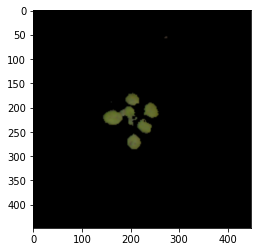

(448, 448, 3)
tf.Tensor(10, shape=(), dtype=int32)


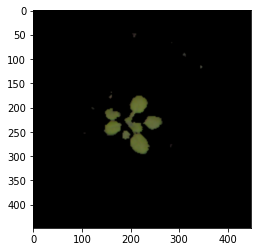

(448, 448, 3)
tf.Tensor(11, shape=(), dtype=int32)


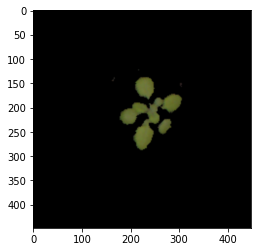

(448, 448, 3)
tf.Tensor(16, shape=(), dtype=int32)


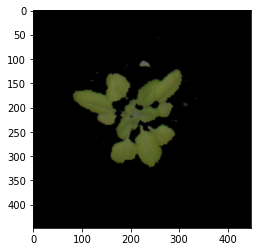

(448, 448, 3)
tf.Tensor(6, shape=(), dtype=int32)


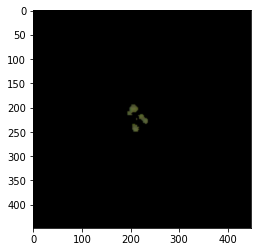

In [ ]:
# Simple check

for image, count in train_dataset.take(5):
  print(image.shape)
  print(count)
  plt.imshow(image.numpy())
  plt.show()

## Hyperparams, Repeat and Batching

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 150
repeat_count = None

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).repeat(repeat_count).batch(BATCH_SIZE).prefetch(5)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).repeat(repeat_count).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)


## Regression Model

In [ ]:
def Conv_LRN_relu(input_tensor, filters, kernel):
    conv = layers.Convolution2D(filters, kernel, padding = "valid", strides = 1)(input_tensor)
    #conv = layers.LayerNormalization()(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation("relu")(conv)
    return conv

In [ ]:
input = layers.Input(shape=(448, 448, 3))

conv_start = layers.Convolution2D(3, (9,9), padding="same")(input)
conv1 = Conv_LRN_relu(conv_start, 16, (9,9))   # TensorShape: [16,440,400]
conv2 = Conv_LRN_relu(conv1, 16, (9,9))   # TensorShape: [16,432,432]
max_pool_1 = layers.MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv2)   # TensorShape: [16,216,216]

conv3 = Conv_LRN_relu(max_pool_1, 32, (9,9))   # TensorShape: [32,208,208]
conv4 = Conv_LRN_relu(conv3, 32, (9,9))   # TensorShape: [32,200,200]
max_pool_2 = layers.MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv4)   # TensorShape: [32,100,100]

conv5 = Conv_LRN_relu(max_pool_2, 64, (5,5))   # TensorShape: [64,96,96]
conv6 = Conv_LRN_relu(conv5, 64, (5,5))   # TensorShape: [64,92,92]
max_pool_3 = layers.MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv6)   # TensorShape: [64,46,46]

conv7 = Conv_LRN_relu(max_pool_3, 128, (5,5))   # TensorShape: [128,42,42]
conv8 = Conv_LRN_relu(conv7, 128, (5,5))   # TensorShape: [128,38,38]
conv9 = Conv_LRN_relu(conv8, 128, (5,5))   # TensorShape: [128,34,34]
max_pool_4 = layers.MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv9)   # TensorShape: [128,17,17]

conv10 = Conv_LRN_relu(max_pool_4, 256, (5,5))   # TensorShape: [256,13,13]
conv11 = Conv_LRN_relu(conv10, 256, (5,5))   # TensorShape: [256,9,9]
conv12 = Conv_LRN_relu(conv11, 256, (5,5))   # TensorShape: [256,5,5]
conv13 = Conv_LRN_relu(conv12, 256, (5,5))   # TensorShape: [256,1,1]

flat = layers.Flatten()(conv13)

fc1 = layers.Dense(256)(flat)
#dropout = layers.Dropout(0.5)(fc1)
fc2 = layers.Dense(512)(fc1)

output = layers.Dense(1)(fc2)

reg_model = Model(inputs=[input], outputs=[output])
reg_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 448, 448, 3)       732       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 440, 440, 16)      3904      
_________________________________________________________________
batch_normalization (BatchNo (None, 440, 440, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 440, 440, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 432, 432, 16)      20752     
_________________________________________________________________
batch_normalization_1 (Batch (None, 432, 432, 16)     

## Loss Function and Tensorboard Setup

In [ ]:
# Using MSE as a loss
#mse = tf.keras.losses.MeanSquaredError()

# Smooth L1 loss
huber_loss = tf.keras.losses.Huber(delta=1.0)

In [ ]:
# Model checkpoint

checkpoint_path = "Checkpoints/"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_loss',
    save_best_only = True,
)

In [ ]:
# Setting up tensorboard 
# https://www.tensorflow.org/tensorboard/get_started

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
# Load the tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/fit

## Training the model

In [ ]:

tf.keras.backend.clear_session()
reg_model.compile(
    loss = huber_loss,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics= ['mse']
)

EPOCHS = 40

fit_history = reg_model.fit(
    train_dataset,
    epochs = EPOCHS,
    verbose = 1,
    callbacks = [tensorboard_callback, model_checkpoint],
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    initial_epoch = 5, # Not useful for training for the first time
    #use_multiprocessing = True
)

Epoch 1/40
 1/20 [>.............................] - ETA: 0s - loss: 13.8106 - mse: 232.3520WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
20/20 [==============================] - ETA: 0s - loss: 10.8996 - mse: 461.6840 WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Checkpoints/assets
20/20 [=================

### Tensorboard Plots

Huber Loss:

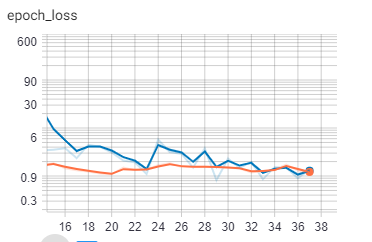

MSE:

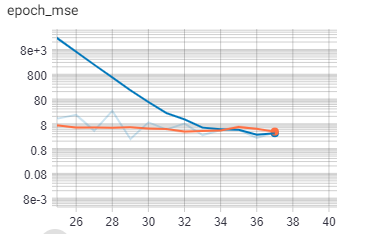

## Evaluation on Test dataset:

In [ ]:
reg_model.evaluate(test_dataset)

3/3 [==============================] - 1s 377ms/step - loss: 1.5559 - mse: 6.1727


[1.5559406280517578, 6.172676086425781]

In [ ]:
reg_model.save("saved_regression_model")

INFO:tensorflow:Assets written to: saved_regression_model/assets


### Load the best model based on validation loss

In [ ]:
best_model = tf.keras.models.load_model(checkpoint_path)
best_model.evaluate(test_dataset)

3/3 [==============================] - 0s 88ms/step - loss: 0.8155 - mean_squared_error: 2.4945


[0.8154884576797485, 2.4944820404052734]

#### Lets see the best and worst predictions on test data:

In [ ]:
checkpoint_path = "Checkpoints/"
best_model = tf.keras.models.load_model(checkpoint_path)

test_set_images = []
test_set_count = []
for image, count in zip(X_test, y_test):
    image, count = get_images_and_counts(image, count)
    image, count = mask_concatenation(image, count)
    test_set_images.append(image)
    test_set_count.append(count)

for i in range(len(X_test)):
    X_test[i], _ = get_images_and_counts(X_test[i], 1)

test_set_images = np.array(test_set_images)
test_set_count = np.array(test_set_count)

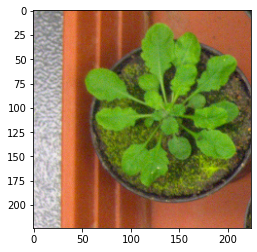

Predicted:  18.989939
Ground Truth:  19
--------------------------------------------------


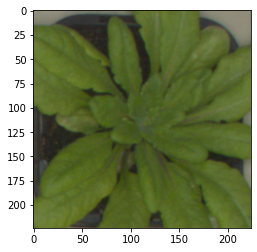

Predicted:  27.985018
Ground Truth:  28
--------------------------------------------------


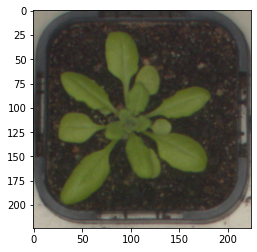

Predicted:  19.02792
Ground Truth:  19
--------------------------------------------------


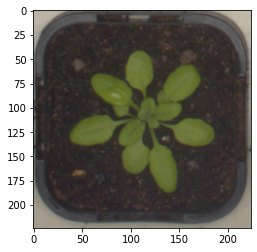

Predicted:  17.74444
Ground Truth:  12
--------------------------------------------------


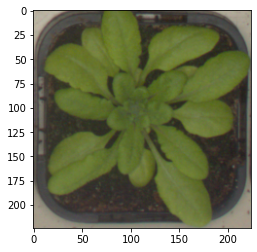

Predicted:  21.063896
Ground Truth:  25
--------------------------------------------------


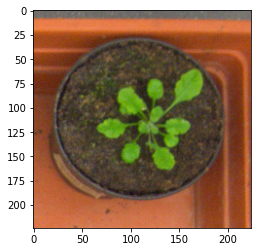

Predicted:  11.173555
Ground Truth:  15
--------------------------------------------------


In [ ]:
predictions = best_model.predict(test_set_images)

predictions = predictions.reshape(predictions.shape[0])

mae = np.abs(test_set_count - predictions)
indexes = np.argsort(mae)

# Best results
plt.imshow(X_test[indexes[1]])
plt.show()
print("Predicted: ", predictions[indexes[1]])
print("Ground Truth: ", test_set_count[indexes[1]])
print("-"*50)

plt.imshow(X_test[indexes[2]])
plt.show()
print("Predicted: ", predictions[indexes[2]])
print("Ground Truth: ", test_set_count[indexes[2]])
print("-"*50)

plt.imshow(X_test[indexes[3]])
plt.show()
print("Predicted: ", predictions[indexes[3]])
print("Ground Truth: ", test_set_count[indexes[3]])
print("-"*50)

# Worst results
plt.imshow(X_test[indexes[-1]])
plt.show()
print("Predicted: ", predictions[indexes[-1]])
print("Ground Truth: ", test_set_count[indexes[-1]])
print("-"*50)

plt.imshow(X_test[indexes[-2]])
plt.show()
print("Predicted: ", predictions[indexes[-2]])
print("Ground Truth: ", test_set_count[indexes[-2]])
print("-"*50)

plt.imshow(X_test[indexes[-3]])
plt.show()
print("Predicted: ", predictions[indexes[-3]])
print("Ground Truth: ", test_set_count[indexes[-3]])
print("-"*50)